# Natural Language Processing And Machine Learning. Innopolis University, Spring 2023. 

# Team: Akhmetzhanov Ravil, Efremov Ivan. MS-RO-21.

# Assignment 3. Named-entity recognition. 

## 1. Overview on methods.

Task of named-entity recognition (NER) can be solved with different methods, like HMM, LSTM, Transformers, etc. But Transformers are current SOTA approach to multiple NLP tasks, NER is not an expection. So it's been decided to use transformers for our task.

Transformers are availible in following libraries:
* Spacy
* DeepPavlov
* HuggingFace

Despite we've found transformer NER guides for:
* DeepPavlov - http://docs.deeppavlov.ai/en/master/features/models/NER.html
* HuggingFace - https://huggingface.co/dslim/bert-base-NER

It's been decided to use Spacy because:
1) It's overall NLP tool with many features. Knowing this library can be very helpfull in the future.
2) It's basic data format for NER training more similar to our data format than in DeepPavlov, HuggingFace

# 2. Importing and installing dependencies

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin


2023-04-02 17:31:10.327488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-02 17:31:10.329713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-02 17:31:10.330186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
spacy.__version__

'3.5.1'

In [ ]:
!python3 -m spacy download ru_core_news_sm

Transformers training can take a lot of time, so it's been decided to take smallest Transformer model that is trained for Russian Language - "ru_core_news_sm". 

We've created a config file (**config.cfg**) that explains model architecture.

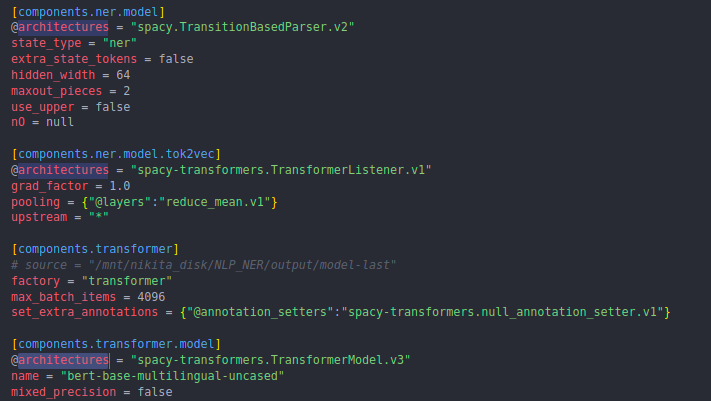

Spacy's **ru_core_news_sm** uses **bert-base-multilingual-uncased** under the hood. It also performs tokenization and other kind of preprocessing instead of us.

In [3]:
# Load Russian text model
import ru_core_news_sm


Example of Spacy NER. As we can see, it works out of the box in few lines of code.

In [3]:
nlp = ru_core_news_sm.load()

path = 'data/test_data/1135.txt'

with open(path, 'r') as text:
    doc = nlp(text.read())

spacy.displacy.render(doc, style="ent", jupyter=True)

# 3. Data Preprocessing

* Guide for NER in SpaCy - https://github.com/dreji18/NER-Training-Spacy-3.0/blob/main/NER%20Training%20with%20Spacy%20v3%20Notebook.ipynb

* Data for NER in SpaCy should have a format of [(TEXT,  {'entities':[(START, END, 'entity name')] })]

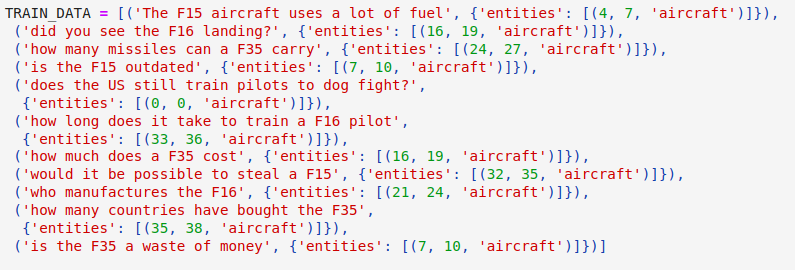

In [4]:
# Reading all filenames into a list

rootdir = 'data/train_data'

file_pairs = []

# Walking through the directory and its subdirectories
for root, directories, files in os.walk(rootdir):
    # Looping through each file in the directory
    for file in files:
        # Checking if the file has a .txt or .ann extension
        if file.endswith('.txt'):
            # Checking if the corresponding .ann file exists
            ann_file = os.path.join(root, file.replace('.txt', '.ann'))
            if os.path.exists(ann_file):
                # Adding the pair of files to the list
                file_pairs.append({'data' : os.path.join(root, file), 'label': ann_file})


In [5]:
# Убрать пересечения, иначе не происходит тренировка
def remove_overlapping_entities(entities):
    filtered_entities = []
    for entity in entities:
        overlapping = [e for e in filtered_entities if not (entity[1] <= e[0] or entity[0] >= e[1])]
        if not overlapping:
            filtered_entities.append(entity)
        else:
            # Remove overlapping entities if the current entity is longer
            for e in overlapping:
                if entity[1] - entity[0] > e[1] - e[0]:
                    filtered_entities.remove(e)
                    filtered_entities.append(entity)
    return filtered_entities

train_data = []

count = 0
# Spacy train format
for i in file_pairs:
    # Reading labels
    entities = []
    with open(i['label'], 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('T'):
                # Splitting the line by tab
                parts = line.split('\t')
                # If string has no exceptions
                if ';' not in parts[1]:
                    parts = parts[1].split(' ')
                    # Extracting the label, start and end positions
                    label = parts[0]
                    start = int(parts[1])
                    end = int(parts[2])
                    # Appending the extracted entity to the list
                    entities.append((start, end, label))
                else:
                    count += 1

    # Removing overlapping entities and keeping the longest entity
    entities = remove_overlapping_entities(entities)

    # Creating a dictionary with the 'entities' key and the extracted entities as values
    label = {'entities': entities}

    with open(i['data'], 'r') as file:
        train_data.append((file.read(), label))

In [6]:
print(f'Number of expections: {count}')

Number of expections: 134


In [7]:
print(f'Files read: {len(train_data)}')

Files read: 841


During processing data into SpaCy format following types of strings were removed:

1) Exceptions, like "T52	EVENT 405 415;432 448	3 человека получили ранения". Dropping them won't affect accuracy much, because there are only 134 strings among 841 files, so only 0.16 expection per file.

2) Overlapping, like:

* T9	TIME 267 286	в понедельник ночью
* T18	DATE 267 280	в понедельник 

We are taking only the largest entity, in this case - **T9	TIME 267 286	в понедельник ночью**. This issue will affect accuracy harder, because overlapping occurs in every file (around 1-3 per file).

In [16]:
# Example of parsed file

train_data[0]

('Брат актрисы Мии Фэрроу покончил жизнь самоубийством\nБританский портал BBC News сообщает об ужасной трагедии, произошедшей накануне. Артист Патрик Фэрроу был найден мертвым. Тело 66-летнего Патрика Фэрроу было найдено в его картинной галерее в Каслтоне, штат Вермонт в понедельник ночью, а его смерть вызывала подозрение у полиции США. Однако позже полицией были опубликованы данные о том, что по результатам экспертизы стало ясно о самоубийстве.\n\nМенеджер Мии Фэрроу сказал что его семья «оплакивает трагическую потерю любимого мужа, отца, дедушки, брата и дяди». «Они очень ценят поддержку друзей в это трудное время»\xa0— добавил он.\n\nПатрик Фэрроу получил несколько национальных премий за его достижения в области скульптуры.\n',
 {'entities': [(13, 23, 'PERSON'),
   (53, 63, 'COUNTRY'),
   (71, 79, 'ORGANIZATION'),
   (133, 139, 'PROFESSION'),
   (140, 153, 'PERSON'),
   (179, 189, 'AGE'),
   (190, 204, 'PERSON'),
   (244, 252, 'CITY'),
   (259, 266, 'STATE_OR_PROVINCE'),
   (323, 33

In [22]:
type(doc.ents[0])

spacy.tokens.span.Span

# 4. Model training

In [23]:
db = DocBin()  # create a DocBin object

for text, annot in tqdm(train_data):  # data in previous format
    doc = nlp.make_doc(text)  # create doc object from text
    ents = []

    # Remove overlapping entities
    annot["entities"] = remove_overlapping_entities(annot["entities"])

    for start, end, label in annot["entities"]:  # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if not span is None:
            ents.append(span)

    # Убрать лишние пробелы, иначе не происходит тренировка
    doc.ents = ents  # label the text with the ents
    for ent in doc.ents:
        if ent[0].is_space or ent[-1].is_space:
            # print("PROBLEM", ent) # add info as appropriate
            # Get the text of the span and remove leading/trailing whitespace
            text = ent.text.strip()
            # Calculate the new start and end positions of the entity span
            start = ent.start + len(ent.text) - len(text) if ent[0].is_space else ent.start
            end = ent.end - len(ent.text) + len(text) if ent[-1].is_space else ent.end
            # Create a new entity span with the modified start/end positions
            new_ent = spacy.tokens.span.Span(doc, start, end, label=ent.label_)
            # Replace the original entity with the new one
            doc.ents = [new_ent if e == ent else e for e in doc.ents]
    db.add(doc)

db.to_disk("./train.spacy")  # save the docbin object


 22%|██▏       | 185/841 [00:00<00:01, 593.89it/s]

PROBLEM В 1999—2000 
PROBLEM 25 ноября 2000 
PROBLEM 1990 
PROBLEM 1992 
PROBLEM 2001 
PROBLEM 2006 
PROBLEM 2002 
PROBLEM летом 2011 
PROBLEM 1989 
PROBLEM декабрь 1992 
PROBLEM В августе-сентябре 1998 
PROBLEM С сентября 2000 
PROBLEM В 2001—2009 
PROBLEM в 1931 
PROBLEM 25 июля 1959 
PROBLEM 1962 
PROBLEM в 1995—2002 
PROBLEM в 1999—2005 


 71%|███████▏  | 601/841 [00:00<00:00, 606.39it/s]

PROBLEM в 2006—2008 
PROBLEM  млн
PROBLEM 53 


 93%|█████████▎| 783/841 [00:01<00:00, 590.96it/s]

PROBLEM С 3 по 12 октября 2012 
PROBLEM 10 января 2011 


100%|██████████| 841/841 [00:01<00:00, 612.16it/s]


You can donwload **saved_models** from the cloud:
https://cloud.mail.ru/public/USyJ/xZrj9Skj9

In [ ]:
nlp1 = spacy.load("saved_models/model-best") #load the best model

# 5. Saving and testing

In [5]:
# Extract entity label, start and end positions
entities = [(ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]

# Print the entities in the desired format
for ent in entities:
    print(ent[0], ent[1], ent[2])

FACILITY 25 28


In [13]:
directory = 'data/test_data'

with open("results.txt", 'w') as out:
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if not filename.endswith(".txt"):
            continue
        with open(filepath, "r") as file:
            text = file.read()
            doc = nlp1(text) 
            # Extract entity label, start and end positions
            entities = [(ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]

            # Print the entities in the desired format
            ann_filename = filename.replace('.txt', '.ann')
            out.write(f"{ann_filename}\n")
            for ent in entities:
                out.write(f"{ent[0]} {ent[1]} {ent[2]}\n")
                

Let's have a look on trained model performance.

In [9]:
spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter


# 6. Conclusion

Our model showed f1 score of 0.746. It's a good result for a relatively small model. Here are a few ideas of improving result:

1) **Possible overfitting** in the end of training our model showed f1 = 1 on a valid test. It happened, because:

    * Mistake in splitting the data: our data was not spliited on train and valid. And f1 during training was evaluated on train set itself. It's a huge mistake.

    * We didn't early stop the model, when f1 was almost 1.

    Handling this 2 issues would improve the results.

2) Taking a bigger model.

But, since we've got an OK score from a first shot - we've decided not to improve the results anymore.

During this assignment we've gained experience in building NER training pipeline using SpaCy and worked with SOTA BERT transformer model.